In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
# File Loading
from trace_file_loader import get_breath_df, equalize_len_trace
from lossplots import plot_loss
# SkLearn Packages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Torch Packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

# Experiment 1
## Parameters:
- Hidden layers = 100
- Num_layers = 1
- Trace Length = 1500
- Regression

# Load and Clean Data

Data is stored in csv files. A data frame is created with the values:
- Trace - Shortened trace to be used as model input (ex. 1400 points before start of breathold, 100 points after start of breathhold)
- Csv_breath_holds - Breath hold length listed in CSV file
- Data_breath_holds - Breath hold length found using the derivative of the full trace
- Full_trace - Complete breath trace data (given in CSV file)
- breathhold_idx - Indices of the full trace identified as breathhold due to the derivative being zero
- bh_start_end - Indices of the full trace where the breathhold starts and ends (based on breathhold_idx)

In [29]:
beforeBH_len = 1400
afterBH_len = 100
trace_len = beforeBH_len+afterBH_len

In [30]:
# breath_df = get_breath_df('data_sdx_', 1400, 100)
# breath_df.to_pickle('breath_pickle')
breath_df = pd.read_pickle('breath_pickle')
breath_df.head(1)

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[0.1319, 0.1363, 0.1408, 0.1452, 0.1497, 0.154...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"


**Discrepancies:** Only considering files where the breathhold length listed in the CSV files is within 2 seconds of the breathhold length identified using the derivative of the trace to avoid using innacurate breath hold indices.

In [31]:
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]
under2 = under2.reset_index(drop=True)
under2.head(1)

,Trace,Csv_breath_holds,Data_breath_holds,Full_trace,breathhold_idx,bh_start_end
0,"[0.1319, 0.1363, 0.1408, 0.1452, 0.1497, 0.154...",31.29,31.69,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[2661, 2662, 2663, 2664, 2665, 2666, 2667, 266...","(2661, 5829)"


## Plot of Breath Holds

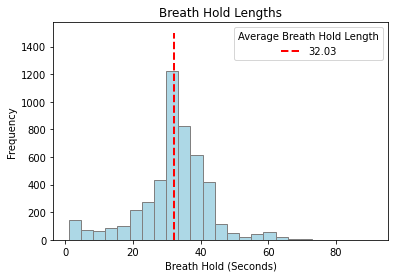

In [33]:
fig, ax = plt.subplots(figsize=(6,4))
bh = np.array(under2['Data_breath_holds'], dtype = 'float32')
ax.hist(bh, bins = 25, color = 'lightblue', edgecolor = "grey")
ax.vlines(x = np.mean(under2['Data_breath_holds']), ymin = 0, ymax = 1500, linestyle='dashed', color = "red", linewidth = 2, label=f"{np.mean(under2['Data_breath_holds']):.2f}")
ax.legend(title = 'Average Breath Hold Length', loc = 'best')
ax.set_title('Breath Hold Lengths')
ax.set_xlabel('Breath Hold (Seconds)')
ax.set_ylabel('Frequency')

plt.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Split and Normalize Data

In [34]:
df = under2

In [35]:
x_train, x_test, y_train, y_test = train_test_split(df['Trace'], df['Data_breath_holds'], test_size=0.15)

In [36]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.4, random_state=1)

In [37]:
# Change type of each row from np.array to list to put into scaler
x_train = np.array([list(row) for row in x_train])
x_val = np.array([list(row) for row in x_val])
x_test = np.array([list(row) for row in x_test])

y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [38]:
scaler = StandardScaler() # creates the scaler
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_val = scaler.transform(x_val)
x_test = scaler.transform(x_test)

### What does the data look like after being scaled?

In [39]:
print(x_train[0:2])
print(x_train.shape)

[[ 0.46074345  0.46295383  0.46538108 ... -0.67841517 -0.67840425
  -0.67839292]
 [ 0.60972806  0.6312029   0.65287878 ...  2.64280041  2.64279835
   2.64279419]]
(2443, 1500)


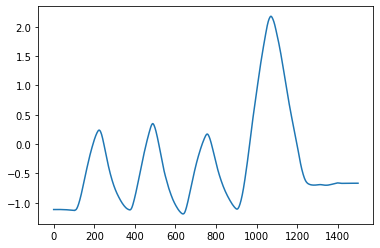

In [41]:
plt.plot(x_train[1020])
plt.show()

In [42]:
print(x_test.shape)

(719, 1500)


# Initialize Data for Model and Create DataLoader

In [43]:
#dataset
from torch.utils.data import Dataset

In [44]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [45]:
dataset = timeseries(x_train,y_train)
valid_dataset = timeseries(x_val,y_val)
test_dataset = timeseries(x_test,y_test)

In [46]:
train_loader = DataLoader(dataset,shuffle=True,batch_size=100)
val_loader = DataLoader(valid_dataset,shuffle=False,batch_size=100)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=100)

## Define LSTM Model (One Step Prediction)

In [47]:
#neural network
from torch import nn

class LSTM_Model(nn.Module):
    def __init__(self):
        super(LSTM_Model,self).__init__()
        self.lstm = nn.LSTM(input_size=1,hidden_size=100,num_layers=1,batch_first=True) # change hidden size
        self.linear = nn.Linear(in_features=100,out_features=1)
        
        
    def forward(self,x):
        output,_status = self.lstm(x)
        output = output[:,-1,:]
        #output = self.linear(torch.relu(output))
        output = self.linear(output)
        return output

model = LSTM_Model()

In [48]:
# Declaring Criterion and Optimizer
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
epochs = 50

## Training Loop

In [49]:
history = []
for i in range(epochs):
    
    train_mse = 0.0
    train_mae = 0.0
    train_loss = 0.0
    train_preds = []
    for x, y in train_loader:
        
        # Clear the gradients
        optimizer.zero_grad()
        # Forward Pass
        ypred = model(x.view(-1,1500,1))       
        # Find the Loss
        loss = criterion(ypred,y.view(-1,1))      
        # Calculate gradients
        loss.backward()       
        # Update Weights
        optimizer.step()      
        # Calculate L1 Loss
        train_loss += loss.item()
        # Calculate MAE
        ypred = ypred.detach().numpy()
        train_mae += mean_absolute_error(ypred, y.view(-1,1))
        # Calculate MSE
        train_mse += mean_squared_error(ypred, y.view(-1,1))
        # R^2
        
        train_preds.append(ypred)
        
    valid_mse = 0.0
    valid_mae = 0.0
    valid_loss = 0.0
    val_preds = []
    for x, y in val_loader:
        # Forward Pass
        ypred = model(x.view(-1,1500,1))
        # Find the Loss
        loss = criterion(ypred,y.view(-1,1))
        # Calculate L1 Loss
        valid_loss += loss.item()
        # Calculate MAE
        ypred = ypred.detach().numpy()
        valid_mae += mean_absolute_error(ypred, y.view(-1,1))
        # Calculate MSE
        valid_mse += mean_squared_error(ypred, y.view(-1,1))
        
        val_preds.append(ypred)

    history.append((train_loss/len(train_loader),valid_loss/len(val_loader)))
    if i%2 == 0:
        torch.save(model, 'lstm_single_output')
        print(f'Epoch {i+1} \t Training Loss: {train_loss/len(train_loader)} \tValidation Loss: {valid_loss/len(val_loader)}')
        print(f'\t\t Training MAE: {train_mae/len(train_loader)} \tValidation MAE: {valid_mae/len(val_loader)}')
        print(f'\t\t Training MSE: {train_mse/len(train_loader)} \tValidation MSE: {valid_mse/len(val_loader)}')
        print()
    
    

Epoch 1 	 Training Loss: 1104.5338159179687 	Validation Loss: 947.6842256433823
		 Training MAE: 31.45291130065918 	Validation MAE: 29.06017438103171
		 Training MSE: 1104.5338256835937 	Validation MSE: 947.6842005112592

Epoch 3 	 Training Loss: 612.6196203613281 	Validation Loss: 527.794386919807
		 Training MAE: 22.86048355102539 	Validation MAE: 21.201464148128736
		 Training MSE: 612.6196240234375 	Validation MSE: 527.7943851246554

Epoch 5 	 Training Loss: 385.9055871582031 	Validation Loss: 336.80261050953584
		 Training MAE: 17.768428382873534 	Validation MAE: 16.56061778349035
		 Training MSE: 385.90559936523437 	Validation MSE: 336.80261050953584

Epoch 7 	 Training Loss: 263.91483215332033 	Validation Loss: 230.03091430664062
		 Training MAE: 14.240935440063476 	Validation MAE: 13.255262094385484
		 Training MSE: 263.9148376464844 	Validation MSE: 230.0309134090648

Epoch 9 	 Training Loss: 191.02193725585937 	Validation Loss: 168.92812975715188
		 Training MAE: 11.642076034

## Plot Loss

In [50]:
history = torch.tensor(history)

In [51]:
#torch.save(model, 'lstm_bh_epochs')

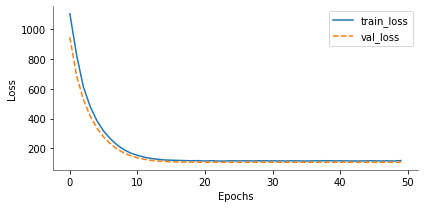

In [54]:
plot_loss(history, maxy = 50)

In [ ]:
#test set actual vs predicted
test_set = timeseries(x_test,y_test)
test_pred = model(test_set[:][0].view(-1,1500,1)).view(-1)
plt.scatter(test_set[:][1].view(-1), test_pred.detach().numpy(),label='predicted')
plt.show()

In [50]:
test_pred = model(test_set[:][0].view(-1,1500,1)).view(-1)